# 02 Seasonal Mosaics with the Open Data Cube

"The primary aim of this pilot is to seek to justify the business case for a full UK S1 and S2 ODC which would, if successful form phase 2. To address this we will build a pilot ODC and undertake a new approach to seasonal S2 mosaics, which has been identified as a key user requirement."

<img src="./data/area_interest.png" alt="Alternative text" />

We are primarily interested in the red boundary delineating the South Downs National Park (SDNP). As the image above shows the boundary covers two sentinel 2 tiles. The SNDP does not have the capacity in terms of storage or processsing tools and knowledge to work with deep stacks of data. They do use imagery when it is 'cloud free' which occurs 4-5 times a year across the park. These factors are significant limitations to expanding the use of Sentinel 2 data. They have not been using the ARD data or the Earth Observation Data Service https://earthobs.defra.gov.uk/ as its use is resticted to certain bodies within Defra. 
Being able to use ARD data alongside the compute would be a significant step change for them

In this notebook we will be stepping through how to use the deep temporal stack of sentinel 2 data and create a seasonal mosaic and then to download the data to be used in a GIS. To re emphasis a key point, search and discovery is still hard (especially to non technical users), download and storage of large volumes of data is inpractical and wasteful AND hard to manage. Being able to compute this meaningfully is beyond the current means. To appreciate the solution that the ODC brings is first to appreciate the pain of the problem.

There is no known reason why this method could not work for all the national park or infact any public body. The user would need to change the input area (AOI) and the date range only

In [1]:
import datacube
import geopandas as gpd
import sys
sys.path.append('./utils')
import jncc_utils
import numpy as np
import pandas as pd
import rasterio
import xarray as xr
import matplotlib.pyplot as plt

<AxesSubplot:>

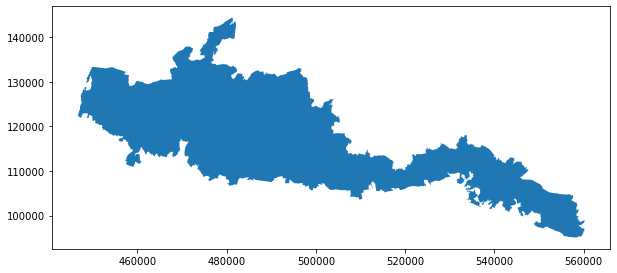

In [2]:
gdf = gpd.read_file('./data/SDNP.shp')
gdf.plot(figsize = (10,10))

Build the query for the open data cube and load it. In this example we will choose the data from summer 2019

In [3]:
dc = datacube.Datacube()

query = {
    'time': ('2019-06-01','2019-08-31'),
    'output_crs': 'epsg:27700',
    'x': (gdf.total_bounds[0], gdf.total_bounds[2]),
    'y': (gdf.total_bounds[1], gdf.total_bounds[3]),
    'crs': 'epsg:27700',
    'resolution': (-10,10),
    'measurements':('red','green','blue','fmask', 'vmask')
}

ds = dc.load(product='sentinel2',
            dask_chunks = {},
            **query)
ds

<xarray.Dataset>
Dimensions:      (time: 48, y: 4940, x: 11371)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-01T11:06:21 ... 2019-08-30T11:...
  * y            (y) float64 1.444e+05 1.444e+05 ... 9.506e+04 9.504e+04
  * x            (x) float64 4.466e+05 4.467e+05 ... 5.603e+05 5.603e+05
    spatial_ref  int32 27700
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    fmask        (time, y, x) uint8 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    vmask        (time, y, x) uint8 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
Attributes:
    crs:           EPSG:27700
    grid_mapping:  spatial_ref

time = 48 means we have 48 images in our cube. This information was returned virtually instantly. Lets inspect the image dates in a pandas dataframe

In [4]:
times = list(ds.time.values)
data = {"times": times}
df = pd.DataFrame(data=data, columns=["times"])
df

,times
0,2019-06-01 11:06:21
1,2019-06-03 10:56:29
2,2019-06-04 11:21:21
3,2019-06-06 11:06:29
4,2019-06-08 10:56:21
5,2019-06-09 11:21:19
6,2019-06-11 11:06:21
7,2019-06-13 10:56:29
8,2019-06-14 11:21:21
9,2019-06-16 11:06:29


It would be nice to understand which images were significantly cloudy. The fmask layer contains that information. The ARD fmask contains values 0 = no cloud, 1 = cloud and 2 = shadow. So lets set the shadow also to 1 (and assume that is cloud for mosaicing purposes) and calculate, for example slice, the percentage cloud cover.

In [5]:
percentage_list=[]
for count, value in enumerate(times):
    data = ds.fmask.isel(time=count).values
    data2 = xr.where(data == 2, 1, data)
    data3 = data2.mean()
    percentage_list.append(data3)

data = {"times": times,
            "clean_percentage": percentage_list}

df = pd.DataFrame(data=data, columns=["times", "clean_percentage"])
df

,times,clean_percentage
0,2019-06-01 11:06:21,0.542576
1,2019-06-03 10:56:29,0.347670
2,2019-06-04 11:21:21,0.002369
3,2019-06-06 11:06:29,0.553996
4,2019-06-08 10:56:21,0.471856
5,2019-06-09 11:21:19,0.001452
6,2019-06-11 11:06:21,0.855497
7,2019-06-13 10:56:29,0.596367
8,2019-06-14 11:21:21,0.002366
9,2019-06-16 11:06:29,0.922259


We have a fair range of cloudy images and it is hard without careful inpsection of either each fmask or each record to understand the distribution of cloud so let's plot it in a graph. The dashed red line is indicative of an acceptable cloud percentage (0.4). Or to put it another way the blue dots below this line are the images we want to use to build our mosaic

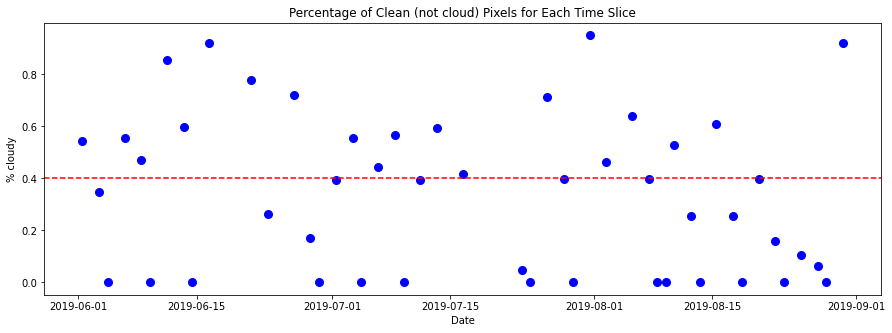

In [6]:
plt.figure(figsize = (15,5))
plt.plot(df["times"].values, df["clean_percentage"].values, 'bo', markersize=8)
plt.axhline(y = 0.4, color = 'r', linestyle = 'dashed')
plt.title("Percentage of Clean (not cloud) Pixels for Each Time Slice")
plt.xlabel("Date")
plt.ylabel("% cloudy")
plt.show()

A word of caution. In there current form the ARD cloud masks are poor. They often see urban areas as cloudy, if your mosaic is likely to be in an urban area you may not get many non cloud masked pixels. A new cloud masking algorithm S2Cloudless (when available) will mitigate this.

Lets select the timeslices corresponding to the threshold above

In [7]:
timeslices = list(df.index[df.clean_percentage < 0.4])
print(timeslices)

[1, 2, 5, 8, 11, 13, 14, 15, 17, 20, 21, 24, 25, 27, 28, 32, 33, 34, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46]


lets check to see if the image really is cloud free (image 44)

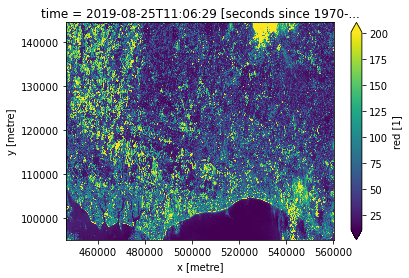

In [8]:
cloud_free_check = ds.red.isel(time=44)
cloud_free_check.plot(robust=True)

The above is slice 44 with 0.10 cloud (a good image) but we do need to remember that the cloud mask can be very misleading, just because fmask is 0 doesn't mean image is cloud free! have a alook at time slice 2 - which report clouds of 0.002

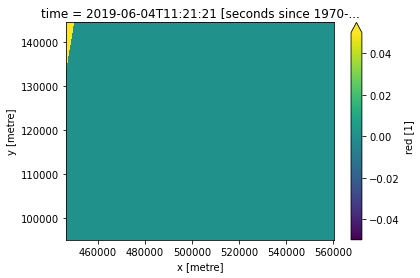

In [9]:
cloud_free_check = ds.red.isel(time=2)
cloud_free_check.plot(robust=True)

That is because just a tiny part of the image covers are AOI! Fortunately we also have another layer call vmask which shows the amount of the scene having pixels. Lets take a look at this

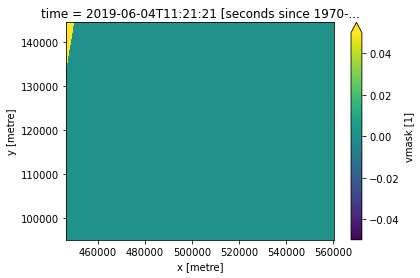

In [10]:
vmask_check = ds.vmask.isel(time=2)
vmask_check.plot(robust=True)

Using this knowledge we need to build a valid and a cloud mask dataset - in the next notebook we will do this. (note the reason to do it this way is the pilot is limited in memory).

In [11]:
ds2 = ds.isel(time=timeslices)
valid = ds2.where(ds2.vmask == 1)
masked = ds2.where(ds2.fmask == 0)

notebook 04 follows on...

In [12]:
valid

<xarray.Dataset>
Dimensions:      (time: 28, y: 4940, x: 11371)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-03T10:56:29 ... 2019-08-28T11:...
  * y            (y) float64 1.444e+05 1.444e+05 ... 9.506e+04 9.504e+04
  * x            (x) float64 4.466e+05 4.467e+05 ... 5.603e+05 5.603e+05
    spatial_ref  int32 27700
Data variables:
    red          (time, y, x) float64 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    fmask        (time, y, x) float64 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    vmask        (time, y, x) float64 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
Attributes:
    crs:           EPSG:27700
    grid_mapping:  spatial_ref